In [1]:
import pandas as pd

In [2]:
# Load dataset

from tdc.multi_pred import MTI

data = MTI(name = 'miRTarBase')
data = data.neg_sample(frac = 1)
split = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
CUT_OFF = 1000

template = """### Instructions: Answer the following question about miRNA protein interactions. 
### Context: MicroRNAs (miRNAs) are, small non-coding RNAs with 18–25 nucleotides, which are central regulators at the 
post-transcriptional level in both animals and plants. Perfect or near-perfect complementary binding of miRNAs and their 
target mRNA negatively regulates gene expression by accelerating mRNA degradation or suppressing mRNA translation.
### Question: Given the miRNA mature sequence and target amino acid sequence, predict whether 
(A) the miRNA and target do not interact (B) the miRNA and target interact
miRNA sequence: {}
Target amino acid sequence: {}
### Answer: {}"""


In [4]:
split["train"].head()

,miRNA_ID,miRNA,Target_ID,Target,Y
0,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,817365,MAATNTILAFSSPSRLLIPPSSNPSTLRSSFRGVSLNNNNLHRLQS...,1
1,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,817365,MAATNTILAFSSPSRLLIPPSSNPSTLRSSFRGVSLNNNNLHRLQS...,1
2,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,837405,MAKGVAVLNSSEGVTGTIFFTQEGDGVTTVSGTVSGLKPGLHGFHV...,1
3,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,837405,MAKGVAVLNSSEGVTGTIFFTQEGDGVTTVSGTVSGLKPGLHGFHV...,1
4,ath-miR398a-3p,UGUGUUCUCAGGUCACCCCUU,817365,MAATNTILAFSSPSRLLIPPSSNPSTLRSSFRGVSLNNNNLHRLQS...,1


<Axes: ylabel='Target'>

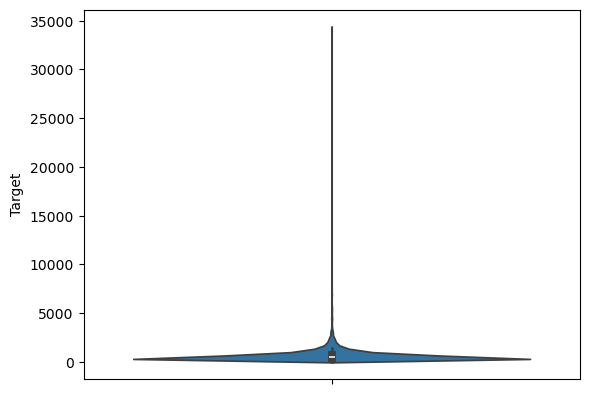

In [5]:
import seaborn as sns

sns.violinplot(split["train"]["Target"].apply(lambda x: len(x)))

In [6]:
split["train"] = split["train"].loc[split["train"]["Target"].str.len()< CUT_OFF]
split["valid"] = split["valid"].loc[split["valid"]["Target"].str.len()< CUT_OFF]
split["test"] = split["test"].loc[split["test"]["Target"].str.len()< CUT_OFF]

In [7]:
# process dataset

def formatting_prompts_func(examples):
    miRNA = examples["miRNA"]
    Target = examples["Target"]
    outputs       = examples["Y"]
    token_sizes = []
    texts = []
    for p,m,o in zip(miRNA, Target, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "(B)" if o else "(A)")
        texts.append(text)
        token_sizes.append(len(text))
    return { "text" : texts, "miRNA":miRNA, "Target":Target, "outputs":outputs, "token_size":token_sizes, "ds_ident":"MTI_miRTarBase"}

def formatting_prompts_func_test(examples):
    miRNA = examples["miRNA"]
    Target = examples["Target"]
    outputs       = examples["Y"]
    token_sizes = []
    texts = []
    for p,m,o in zip(miRNA, Target, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m, "")
        texts.append(text)
        token_sizes.append(len(text))
    return { "text" : texts, "miRNA":miRNA, "Target":Target, "outputs":outputs, "token_size":token_sizes, "ds_ident":"MTI_miRTarBase"}

In [8]:
train_dataset = formatting_prompts_func(split["train"])
valid_dataset = formatting_prompts_func_test(split["valid"])
test_dataset = formatting_prompts_func_test(split["test"])

In [9]:
len(train_dataset["text"]), len(valid_dataset["text"]), len(test_dataset["text"])

(483350, 69171, 138399)

<Axes: >

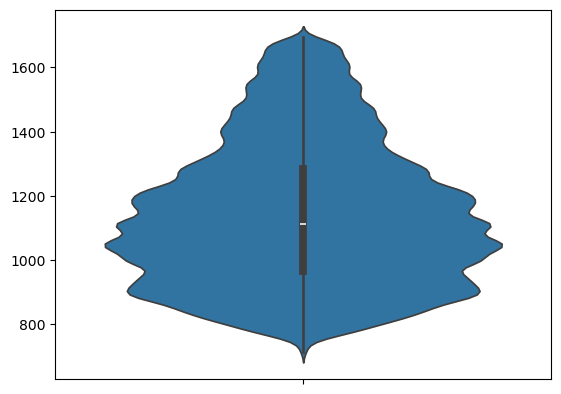

In [10]:
import seaborn as sns

sns.violinplot(train_dataset["token_size"])

In [11]:
import pickle
import os


def dump_file(obj, path, file_name):
    os.makedirs(path, exist_ok=True)
    file_name = os.path.join(path,file_name)
    with open(file_name, "wb") as f0:
        pickle.dump(obj,f0)

In [12]:
dump_file(train_dataset, "processed", "train.pkl")
dump_file(valid_dataset, "processed", "valid.pkl")
dump_file(test_dataset, "processed", "test.pkl")